In [11]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"]
held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Se0.6828410029411316ssion3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

num_sessions = len(held_in_session_ids)
MAX_BATCH_SIZE = 62500 // 2
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...checkout -b twostage origin/twostage
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [13]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 74])
Test
torch.Size([2500, 20, 74])


In [14]:
# Customize cfg here...
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml
    
def cfg_identity(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    cfg.latent_dim = dim
    
def cfg_base(cfg, dim):
    cfg_identity(cfg, dim)
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"
    
cfg.training.epochs = 12001
cfg.latent_dim = 74
cfg.ae.training.lambda_ae_recon = 0.03
cfg.ae.use_two_stage = True
cfg.ae.two_stage.freeze_only_shared = False
cfg.ae.two_stage.lambda_mu = 0.01
cfg.ae.two_stage.lambda_cov = 0.01
cfg.tbfm.training.lambda_fro = 60.0
# Running with two stage ae

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)

---- 0 0.8437785506248474 1.104402780532837 0.43002502620220184 0.4966661334037781


In [6]:
# dim 60
# ---- 0 1.3359395265579224 0.8046253323554993 0.4661109149456024 0.5844032168388367
# ---- 1000 0.4278075695037842 0.6622188687324524 0.5766839385032654 0.6583306789398193
# ---- 2000 0.396166056394577 0.618324875831604 0.6141364574432373 0.6806805729866028
# ---- 3000 0.3778141736984253 0.5973939895629883 0.6342048048973083 0.6913884878158569
# ---- 4000 0.3581080436706543 0.5916580557823181 0.6571977734565735 0.6942155957221985
# ---- 5000 0.34816664457321167 0.5940332412719727 0.6708053946495056 0.6929813623428345
# ---- 6000 0.3581438660621643 0.6191266775131226 0.6658573150634766 0.6801104545593262
# ---- 7000 0.3336026072502136 0.5939902663230896 0.6932620406150818 0.6929448246955872
# ---- 8000 0.3327471911907196 0.6096295714378357 0.6964863538742065 0.6848694086074829
# ---- 9000 0.32028335332870483 0.6060802936553955 0.7111420035362244 0.6866371035575867
# ---- 10000 0.3183406591415405 0.6209917068481445 0.7141416668891907 0.678869366645813
# ---- 11000 0.3536463975906372 0.6276780366897583 0.6893952488899231 0.6756570935249329
# ---- 12000 0.33108434081077576 0.6445168852806091 0.7040227055549622 0.6667747497558594
# Final: 0.6403006315231323 0.6689963936805725

# Dim 60, recon 0.01
# Final: 0.6290900111198425 0.6746326088905334

# Dim 60, recon 0.02
# (0, 0.4652750790119171) (0, 0.5842809677124023)
# (1000, 0.5846171975135803) (1000, 0.6621342897415161)
# (2000, 0.6182869672775269) (2000, 0.6836692094802856)
# (3000, 0.6335306763648987) (3000, 0.6886982321739197)
# (4000, 0.6580140590667725) (4000, 0.6863154768943787)
# (5000, 0.6735500693321228) (5000, 0.6886609196662903)
# (6000, 0.6912528276443481) (6000, 0.6884714365005493)
# (7000, 0.6946881413459778) (7000, 0.6783629655838013)
# (8000, 0.7047398090362549) (8000, 0.6851468086242676)
# (9000, 0.705632746219635) (9000, 0.6886439919471741)
# (10000, 0.7090436816215515) (10000, 0.6628554463386536)
# (11000, 0.7272168397903442) (11000, 0.6862529516220093)
# (12000, 0.7215263247489929) (12000, 0.6816081404685974)
# Final: 0.6828410029411316

# Dim 60, recon 0.005
# Final: 0.6192483901977539 0.6799713373184204

print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

{'MonkeyG_20150918_Session1_M1': 0.6986955404281616, 'MonkeyG_20150925_Session2_S1': 0.5982998013496399}
0.5982998013496399


In [7]:
for idx, tr2 in enumerate(results["test_r2s"]):
    tra_r2 = results["train_r2s"][idx]
    print(tra_r2, tr2)
print(results["final_test_r2"])

(0, 0.45620231330394745) (0, 0.5206488966941833)
(1000, 0.6429260671138763) (1000, 0.6892319917678833)
(2000, 0.6685389280319214) (2000, 0.708501935005188)
(3000, 0.694101095199585) (3000, 0.7201099991798401)
(4000, 0.6939720511436462) (4000, 0.7142893671989441)
(5000, 0.7187677919864655) (5000, 0.7100058794021606)
(6000, 0.7258723676204681) (6000, 0.7053531408309937)
(7000, 0.7187162339687347) (7000, 0.6877652406692505)
(8000, 0.747996598482132) (8000, 0.7000724673271179)
(9000, 0.6704417765140533) (9000, 0.6822025775909424)
(10000, 0.7641828060150146) (10000, 0.6894118785858154)
(11000, 0.7478150129318237) (11000, 0.6722626090049744)
(12000, 0.7395433783531189) (12000, 0.6455835103988647)
0.6484977006912231


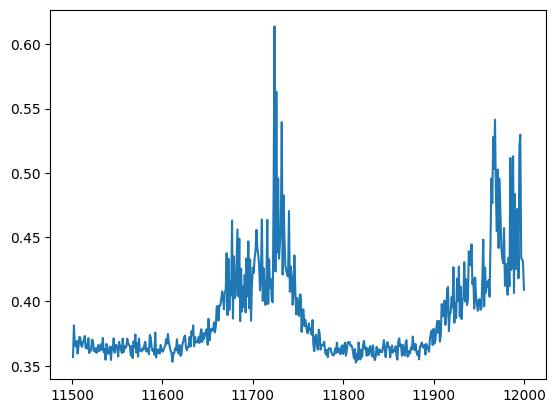

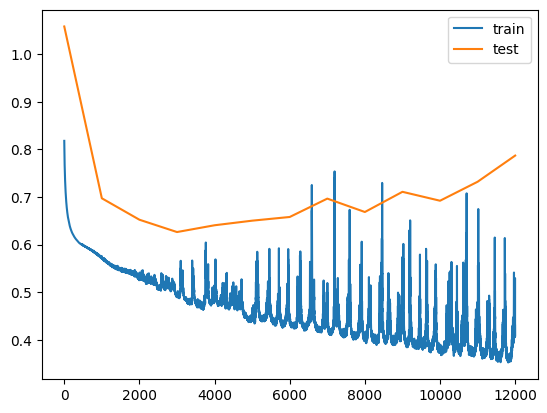

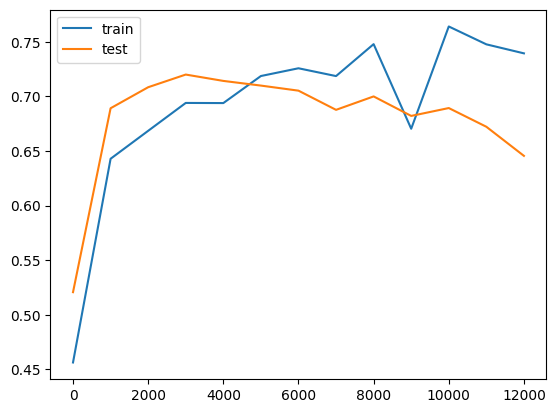

In [8]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [19]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([-0.0614,  0.0382,  0.0541, -0.0395, -0.1412,  0.0947, -0.0753,  0.0451,
         0.0889, -0.0264, -0.0923,  0.0926,  0.0201,  0.0646, -0.2211],
       device='cuda:0')
tensor([-0.0186, -0.1713, -0.0534, -0.1216, -0.0148,  0.0678, -0.0646, -0.0792,
         0.1374, -0.1338,  0.0144, -0.0022, -0.0586, -0.0244,  0.0698],
       device='cuda:0')


tensor([-0.9283, -0.9440, -0.9484, -0.9617, -0.9851, -0.9764, -0.9793, -0.9981,
        -1.0015, -0.9975], device='cuda:0')
------
------
tensor([-3.4481,  2.5487, -2.6079, -3.8549, -2.9441,  3.6644,  0.5317, -2.6417,
        -2.9962,  0.3473], device='cuda:0') tensor([-2.5952,  3.1032, -4.6588, -2.5317, -3.2687,  5.1147,  0.3534, -2.7553,
        -3.2957,  0.4751], device='cuda:0')
tensor([-0.9813, -0.9866, -1.0031, -1.0038, -1.0154, -1.0203, -1.0519, -1.0337,
        -1.0427, -1.0556], device='cuda:0')


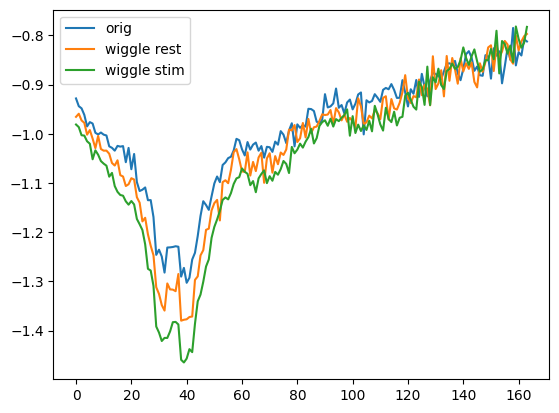

In [9]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]


def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * 1.2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

In [17]:
print(ms.model.instances['MonkeyG_20150925_Session2_S1'].prev_bases[0])

tensor([[-1.6950, -1.6841, -1.5680,  ...,  1.0476, -1.6124,  1.8581],
        [ 1.5737,  0.8381,  0.6144,  ...,  0.4595, -1.4544, -0.4424],
        [ 1.9009,  0.6420,  0.6892,  ...,  1.8129,  1.1658,  1.8373],
        ...,
        [ 1.4457, -0.6197,  1.1864,  ...,  0.7964, -0.7746,  1.1812],
        [-0.5792, -0.3554,  1.8601,  ..., -0.8813, -0.4835,  1.3485],
        [ 1.0957, -1.2948,  1.0056,  ...,  0.2971, -0.7856,  0.9564]],
       device='cuda:0')


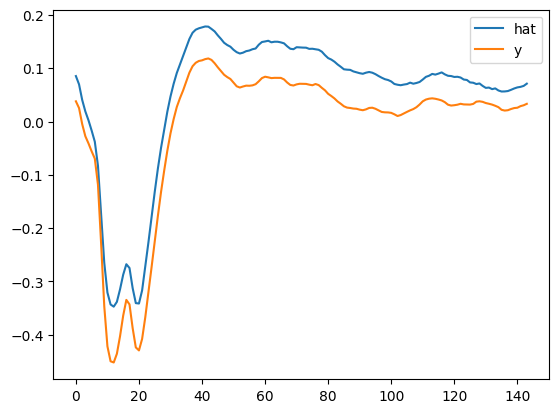

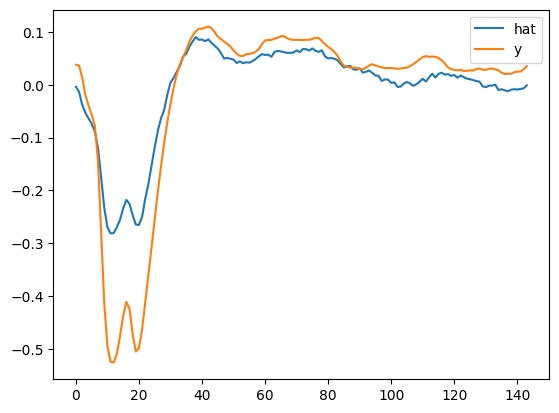

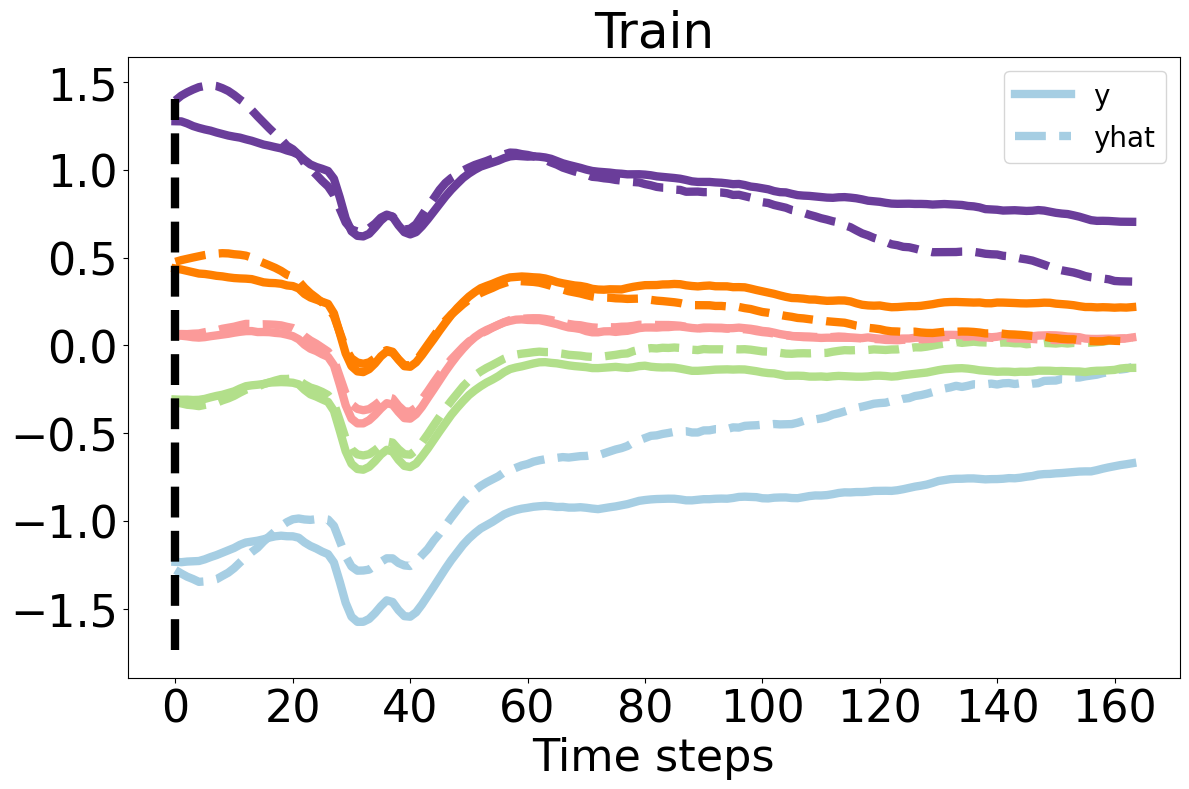

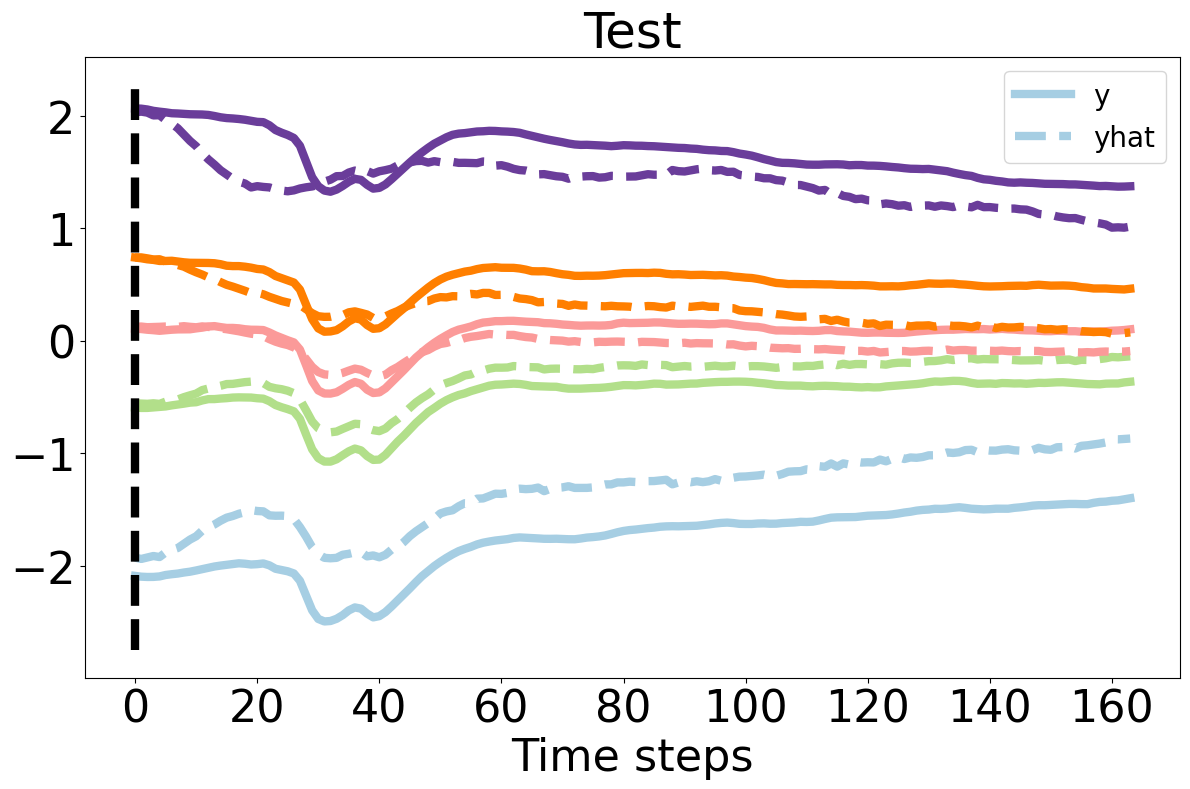

In [10]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)
    
    plt.plot(y_hat_mean[20:, cidx], label="hat")
    plt.plot(y_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()

    plt.plot(y_hat_test_mean[20:, cidx], label="hat")
    plt.plot(y_test_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()
    
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=22)

In [ ]:
# Try:
# cfg.tbfm.module.latent_dim = (16, 32, 64)
# cfg.tbfm.module.embed_dim_stim = (3, 7, 15, 20)

for latent_dim in (16, 32, 64):
    for embed_dim_stim in (3, 7, 15, 20):
        print("---------------", latent_dim, embed_dim_stim)

        # cfg.tbfm.training.lambda_fro = regweight
        # cfg.tbfm.module.num_bases = num_bases
        # cfg.training.grad_clip = grad_clip
        # cfg.latent_dim = latent_dim
        # cfg.tbfm.training.optim.lr_head = lr_head
        # cfg.tbfm.training.lambda_ortho = lambda_ortho
        cfg.tbfm.module.latent_dim = latent_dim
        cfg.tbfm.module.embed_dim_stim = embed_dim_stim
        # cfg.tbfm.module.use_film_bases = True
        # cfg.ae.training.coadapt = True
        cfg.training.epochs = 15001

        ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
        model_optims = multisession.get_optims(cfg, ms)
        
        embeddings_stim, results = multisession.train_from_cfg(
            cfg,
            ms,
            data_train,
            model_optims,Carmen
            embeddings_rest,
            data_test=data_test,
            test_interval=5000,
            epochs=cfg.training.epochs,
            )
        torch.save(results, f"res_{latent_dim}_{embed_dim_stim}.torch")

        del model_optims, ms

--------------- 16 3
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1575546264648438 0.9233913421630859 0.0376604589788864 0.062086887657642365
---- 5000 0.5894997715950012 0.5439465641975403 0.4358087678750356 0.44218406081199646
---- 10000 0.5419514775276184 0.5320742130279541 0.48556982477506 0.4532109498977661


In [7]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)


# (0.4636920392513275, './res_2.0_15_0.1.torch')
# (0.463911235332489, './res_7.0_25_0.1.torch')
# (0.4639878273010254, './res_2.0_15_0.01.torch')
# (0.4647655487060547, './res_2.0_20_0.05.torch')Carmen
# (0.4657297134399414, './res_7.0_20_0.01.torch')
# (0.4676693379878998, './res_7.0_25_0.05.torch')
# (0.4676762521266937, './res_7.0_15_0.01.torch')
# (0.46845221519470215, './res_2.0_20_0.1.torch')
# (0.4699900150299072, './res_2.0_25_0.01.torch')
# (0.4754122197628021, './res_2.0_20_0.01.torch')

(0.4600786566734314, './res_64_15.torch')
(0.46490734815597534, './res_32_20.torch')
(0.4654322862625122, './res_64_7.torch')
(0.4656924605369568, './res_64_3.torch')
(0.46584925055503845, './res_16_3.torch')
(0.4660493731498718, './res_32_7.torch')
(0.467379093170166, './res_32_3.torch')
(0.46820545196533203, './res_16_7.torch')
(0.4695136547088623, './res_32_15.torch')
(0.4742690324783325, './res_16_15.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}


In [33]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=5000, lr=1e-4, weight_decay=0, data_test=data_test)
print(results["final_test_r2s"])

0 0.26425138115882874
100 0.26491639018058777
200 0.264748215675354
300 0.26684728264808655
400 0.2672831118106842
500 0.2647596001625061
600 0.2650896906852722
700 0.26580071449279785
800 0.265520840883255
900 0.26373037695884705
1000 0.2670634984970093
1100 0.2639212906360626
1200 0.2657037675380707
1300 0.26466190814971924
1400 0.264711856842041
1500 0.26455578207969666
1600 0.26615241169929504
1700 0.2642905116081238
1800 0.2637423574924469
1900 0.26559942960739136
2000 0.2651607394218445
2100 0.26683345437049866
2200 0.2674965262413025
2300 0.2640903890132904
2400 0.266634464263916
2500 0.2654741406440735
2600 0.2643529176712036
2700 0.2655819356441498
2800 0.26306602358818054
2900 0.2650347948074341
3000 0.26549193263053894
3100 0.2660302519798279
3200 0.2646785378456116
3300 0.26531359553337097
3400 0.26418811082839966
3500 0.2672420144081116
3600 0.26371559500694275
3700 0.26580724120140076
3800 0.26441678404808044
3900 0.2654988169670105
4000 0.26334694027900696
4100 0.2650299

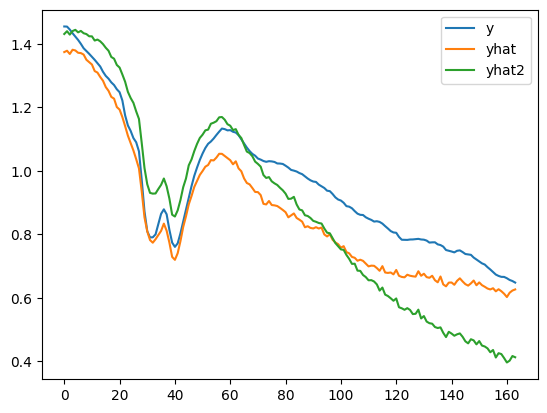

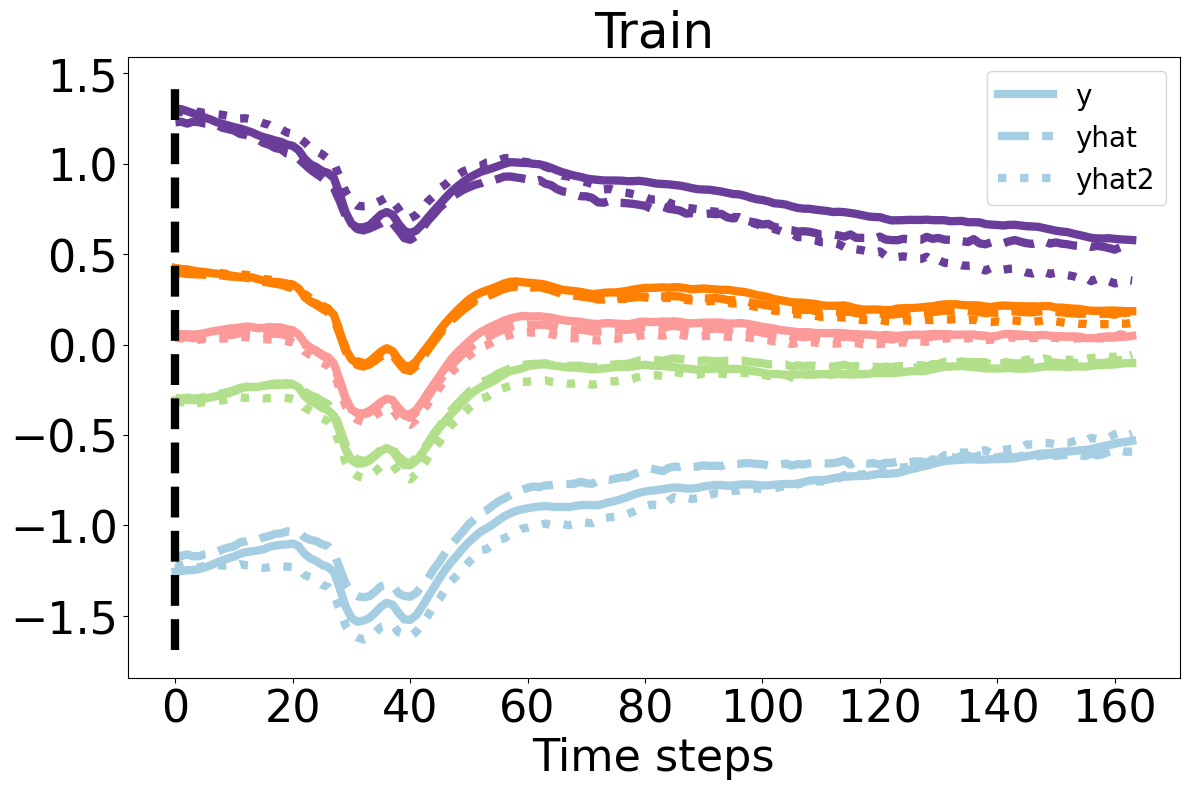

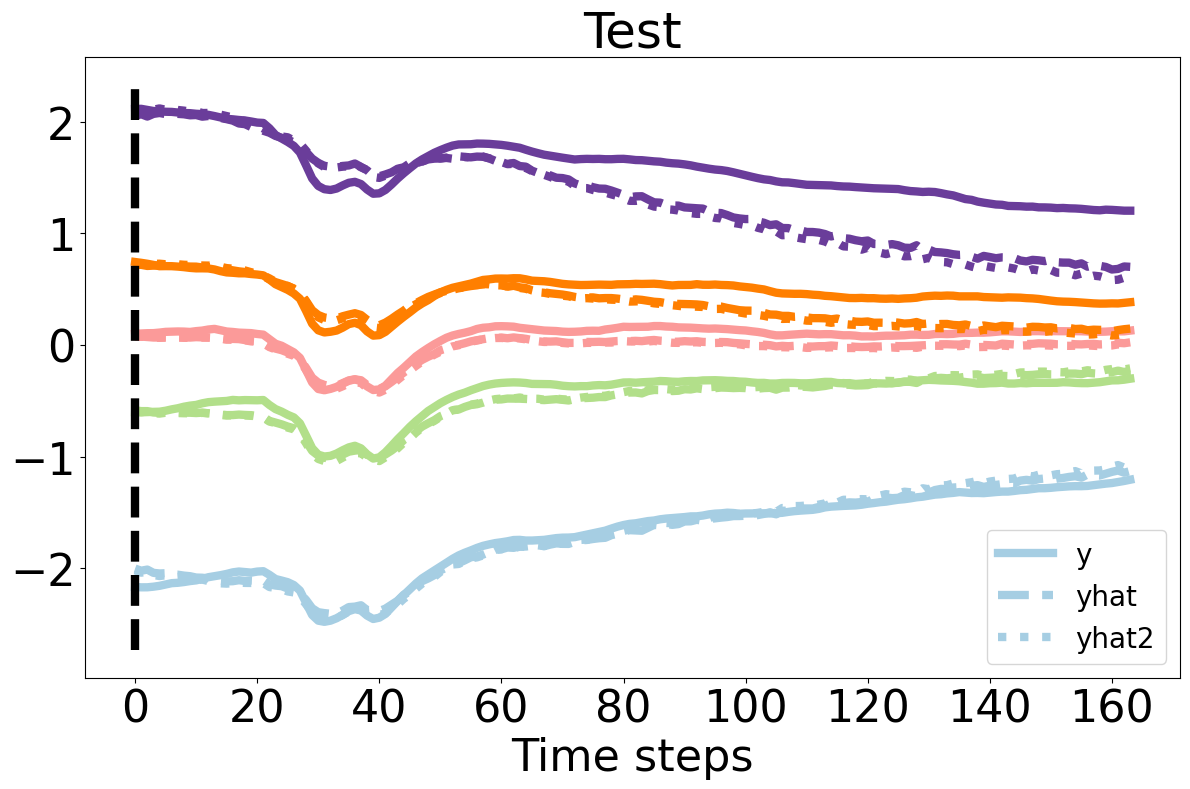

In [34]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])             
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])                    
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)

